In [1]:

import logging
from typing import List, Optional, Union
import pandas as pd
import mplfinance as mpf
import matplotlib.patches as patches
from datetime import datetime
import matplotlib.pyplot as plt

# Configure logging (only to file, no console)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("candlestick_plot.log", mode="w")  # overwrite each run
    ]
)
logger = logging.getLogger(__name__)

In [2]:
class CandlestickPlotter:
    """A class to create candlestick charts with trade rectangles."""

    def __init__(self, config: Optional[dict] = None):
        """Initialize the plotter with configuration.

        Args:
            config (dict, optional): Configuration dictionary for plot settings.
        """
        self.config = config or {
            'figsize': (20, 8),
            'style': 'charles',
            'title': 'Candlestick Chart with Trade Rectangles',
            'main_rect': {'fill_color': 'orange', 'edge_color': 'black', 'alpha': 0.1, 'linewidth': 1.5},
            'sl_rect': {'fill_color': 'red', 'edge_color': 'black', 'alpha': 0.1, 'linewidth': 1.5},
            'tp_rect': {'fill_color': 'green', 'edge_color': 'black', 'alpha': 0.1, 'linewidth': 1.5},
            'golden_outline': {'edge_color': 'gold', 'linewidth': 4}
        }
        # logger.info("CandlestickPlotter initialized with default configuration")

    def _add_rectangle(self, rects: List[patches.Rectangle], x: int, y1: float, y2: float,
                     width: int = 1, **rect_params) -> None:
        """Add a rectangle to the plot with specified parameters.

        Args:
            rects: List to store rectangle patches
            x: Starting x-coordinate
            y1: First y-coordinate
            y2: Second y-coordinate
            width: Rectangle width
            **rect_params: Additional rectangle parameters
        """
        try:
            rects.append(patches.Rectangle(
                (x - 0.5, min(y1, y2)),
                width=width,
                height=abs(y2 - y1),
                facecolor=rect_params.get('fill_color', 'none'),
                edgecolor=rect_params.get('edge_color', 'black'),
                alpha=rect_params.get('alpha', 0.1),
                linewidth=rect_params.get('linewidth', 1)
            ))
        except Exception as e:
            logger.error(f"Error adding rectangle: {str(e)}")

    def plot_candles_with_rects(self, ohlc_df: pd.DataFrame, trades_df: Optional[pd.DataFrame] = None,
                               start_row: int = 0, end_row: Optional[int] = None,
                               title: Optional[str] = None) -> None:
        """Plot candlestick chart with trade rectangles.

        Args:
            ohlc_df: DataFrame with OHLC data (index: datetime, columns: Open, High, Low, Close)
            trades_df: DataFrame with trade data (optional)
            start_row: Starting row index
            end_row: Ending row index (optional)
            title: Chart title (optional)
        """
        try:
            # Validate input DataFrame
            required_columns = ['Open', 'High', 'Low', 'Close']
            if not all(col in ohlc_df.columns for col in required_columns):
                raise ValueError(f"OHLC DataFrame must contain columns: {required_columns}")

            # Prepare view
            view = ohlc_df.iloc[start_row:end_row].copy()
            if view.empty:
                raise ValueError("Selected data slice is empty")

            rects: List[patches.Rectangle] = []

            if trades_df is not None:
                # Validate trades DataFrame
                trade_columns = ['Entry Time', 'Exit Time', 'Entry Price', 'Exit Price']
                if not all(col in trades_df.columns for col in trade_columns):
                    logger.warning(f"Trades DataFrame missing some required columns: {trade_columns}")
                    return

                for _, trade in trades_df.iterrows():
                    try:
                        entry_idx = view.index.get_loc(trade['Entry Time'])
                        exit_idx = view.index.get_loc(trade['Exit Time'])
                        width = exit_idx - entry_idx + 1

                        # Main trade rectangle
                        self._add_rectangle(rects, entry_idx, trade['Entry Price'], trade['Exit Price'],
                                         width=width, **self.config['main_rect'])

                        # Stop Loss rectangle
                        sl_value = trade.get('SL')
                        if pd.notna(sl_value):
                            self._add_rectangle(rects, entry_idx, trade['Entry Price'], sl_value,
                                             width=width, **self.config['sl_rect'])

                        # Take Profit rectangle
                        tp_value = trade.get('TP')
                        if pd.notna(tp_value):
                            self._add_rectangle(rects, entry_idx, trade['Entry Price'], tp_value,
                                             width=width, **self.config['tp_rect'])

                        # Golden outline for winning trades
                        exit_status = trade.get('Exit Status', 'SL')
                        if exit_status.upper() == "TP":
                            main_low = min(trade['Entry Price'], trade['Exit Price'])
                            main_high = max(trade['Entry Price'], trade['Exit Price'])
                            self._add_rectangle(rects, entry_idx, main_low, main_high, width=width,
                                              fill_color='none', **self.config['golden_outline'])

                    except KeyError as e:
                        logger.warning(f"Skipping trade due to missing index: {str(e)}")
                        continue
                    except Exception as e:
                        logger.error(f"Error processing trade: {str(e)}")
                        continue

            # Plot chart
            fig, axlist = mpf.plot(
                view,
                type='candle',
                style=self.config['style'],
                returnfig=True,
                figsize=self.config['figsize'],
                title=title or self.config['title']
            )
            ax = axlist[0]

            # Add rectangles
            for rect in rects:
                ax.add_patch(rect)

            plt.show()
            logger.info("Chart successfully plotted")

        except Exception as e:
            logger.error(f"Error in plot_candles_with_rects: {str(e)}")
            raise

In [3]:

def main():
    """Example usage of CandlestickPlotter."""
    try:
        # Load data
        ohlc = pd.read_csv("applyiedMacd-1.csv", parse_dates=["DateTime"]).set_index("DateTime")
        trades = pd.read_csv("bt.result.csv", parse_dates=["Entry Time", "Exit Time"])

        # Initialize plotter and create plot
        plotter = CandlestickPlotter()
        plotter.plot_candles_with_rects(ohlc, trades, start_row=300, end_row=450)

    except FileNotFoundError as e:
        logger.error(f"Data file not found: {str(e)}")
    except Exception as e:
        logger.error(f"Error in main: {str(e)}")

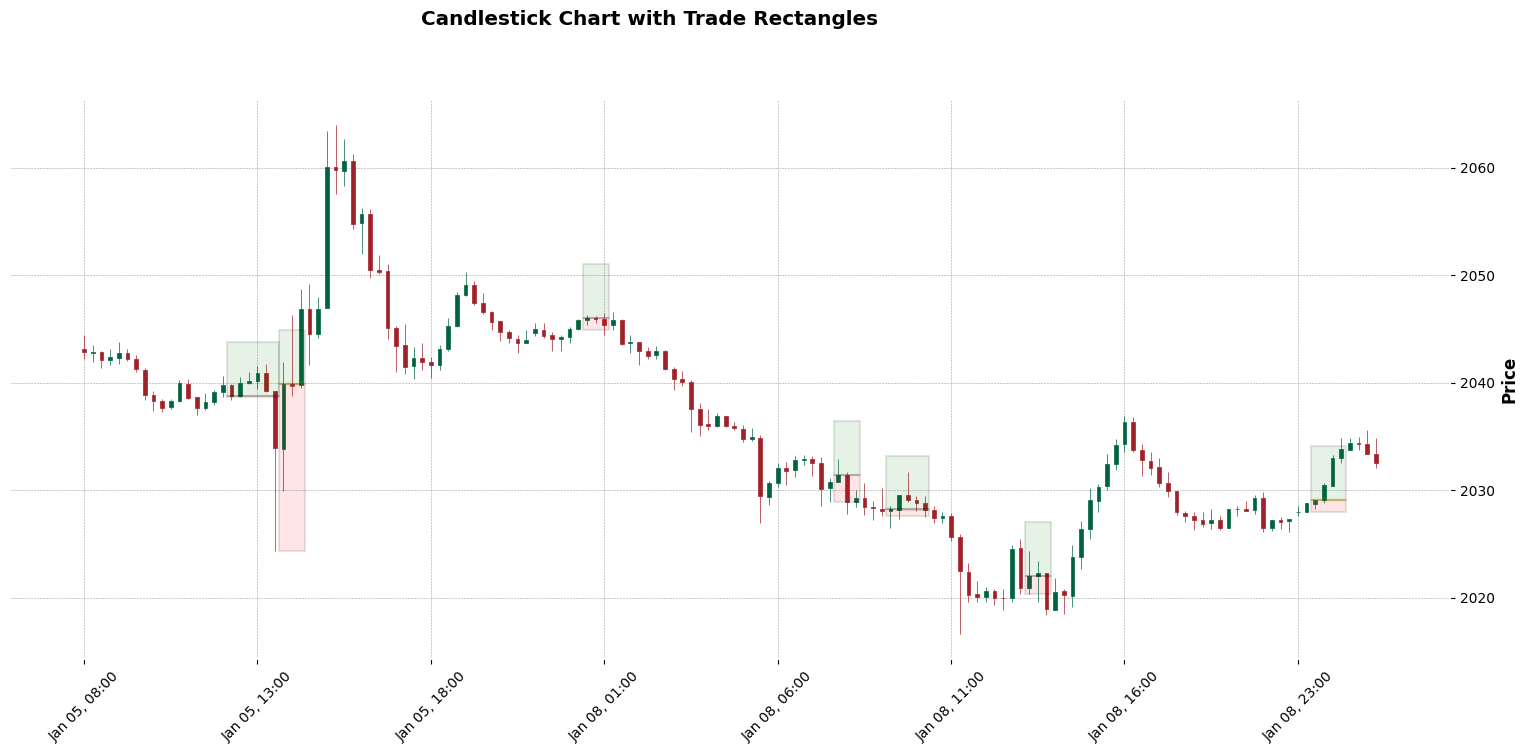

In [4]:

if __name__ == "__main__":
    main()